In [3]:
import numpy as np
import pandas as pd
import random as rand
import requests
import json
import re
from json import loads

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

import math
import gurobipy as gp
from gurobipy import GRB
import requests
from datetime import datetime

# 3명 settlement class화 (출발지 또는 목적지 동일)

In [35]:
class settlement_algorithm():
    def __init__(self, key, loc_info):
        self.key = key
        self.loc_info = loc_info

    def dist(self, addr, addr_info):
        self.addr = addr
        self.addr_info = addr_info
        return ((self.addr_info[self.addr]['lat']-self.loc_info[len(self.loc_info)-1][2])**2 + (self.addr_info[self.addr]['lon']-self.loc_info[len(self.loc_info)-1][1])**2)**1/2

    def dist2(self, addr, addr_info):
        self.addr = addr
        self.addr_info = addr_info
        return ((self.addr_info[self.addr]['lat']-self.loc_info[0][2])**2 + (self.addr_info[self.addr]['lon']-self.loc_info[0][1])**2)**1/2

    def individual_move(self):

        key = self.key
        loc_info = self.loc_info

        ##1 위도 경도 API
        for i in range(len(loc_info)):
            url = f"https://apis.openapi.sk.com/tmap/pois?version=1&searchKeyword={loc_info[i]}&searchkey=all" \
                  f"&searchtypCd=A&reqCoordType=WGS84GEO&resCoordType=WGS84GEO&page=1&count=1&multiPoint=N&poiGroupYn=N"

            headers = {
                "Accept": "application/json",
                "appKey": "l7xxcdd1a30a6b34450a881f8083994a8cd4"
            }

            response = requests.get(url, headers=headers)
            jsonObj = json.loads(response.text)
            loc_info[i].append(float(jsonObj['searchPoiInfo']['pois']['poi'][0]['frontLon']))
            loc_info[i].append(float(jsonObj['searchPoiInfo']['pois']['poi'][0]['frontLat']))

        addr_info = {loc_info[i][0] : {'no': i, 'lon': loc_info[i][1], 'lat': loc_info[i][2]} for i in range(len(loc_info))}

        ##2 혼자 가는 경우 경로 시각화
        passenger_sample = addr_info.keys()

        if key=='A':
            a,b,c,dst = passenger_sample
            pass_2_node = {'a': a, 'b': b, 'c': c, 'dst':dst}
            node_2_pass = {a: 'a', b: 'b', c: 'c', dst: 'dst'}
        else:
            src,a,b,c = passenger_sample
            pass_2_node = {'src': src, 'a': a, 'b': b, 'c': c}
            node_2_pass = {src: 'src', a: 'a', b: 'b', c: 'c'}

        lat = [addr_info[addr]['lat'] for addr in passenger_sample]
        lon = [addr_info[addr]['lon'] for addr in passenger_sample]
        addr = [f'{pas}({node_2_pass[pas]})' for pas in passenger_sample]

        fig, ax = plt.subplots()
        ax.scatter(lon, lat)
        if key=='A':
            for i, txt in enumerate(addr):
                ax.plot([lon[-1], lon[i]], [lat[-1], lat[i]])
        else:
            for i, txt in enumerate(addr):
                try:
                    ax.plot([lon[0], lon[i+1]], [lat[0], lat[i+1]])
                except: pass

        for i, txt in enumerate(addr):
            ax.annotate(txt, (lon[i], lat[i]))
        plt.show()


        ##3 동승시 택시 경유 경로
        if key=='A':
            rout = [[addr,settlement_algorithm(key,loc_info).dist(addr,addr_info)] for addr in passenger_sample]
            rout.sort(key=lambda  x: x[1], reverse=True)
        else:
            rout = [[addr,settlement_algorithm(key,loc_info).dist2(addr,addr_info)] for addr in passenger_sample]
            rout.sort(key=lambda  x: x[1])


        routing = {addr: {'node':node_2_pass[addr],'no':addr_info[addr]['no']} for addr,dis in rout}
        passenger_routing = list(routing.keys())

        lat2 = [addr_info[rou]['lat'] for rou in routing]
        lon2 = [addr_info[rou]['lon'] for rou in routing]

        fig, ax = plt.subplots()
        ax.scatter(lon, lat)
        for i, txt in enumerate(routing):
            try:
                ax.plot([lon2[i], lon2[i+1]], [lat2[i], lat2[i+1]])
            except: pass
        for i, txt in enumerate(addr):
            ax.annotate(txt, (lon[i], lat[i]))
        plt.show()


        ##4 혼자 택시 탔을 때 정보
        individual_distance = []
        individual_duration = []
        individual_cost = []

        url = "https://apis.openapi.sk.com/tmap/routes?version=1&callback=function"

        for i in range(len(loc_info)-1):
            payload = {
                "tollgateFareOption": 16,
                "roadType": 32,
                "directionOption": 1,
                # "endX": addr_info[passenger_routing[-1]]['lon'],
                # "endY": addr_info[passenger_routing[-1]]['lat'],
                "endRpFlag": "G",
                "reqCoordType": "WGS84GEO",
                # "startX": addr_info[passenger_routing[i]]['lon'],
                # "startY": addr_info[passenger_routing[i]]['lat'],
                "gpsTime": datetime.now().strftime('%Y%m%d%H%M%S'), #YYYYMMDDhhmmss
                "speed": 10,
                "uncetaintyP": 1,
                "uncetaintyA": 1,
                "uncetaintyAP": 1,
                "carType": 0,
                "detailPosFlag": "2",
                "resCoordType": "WGS84GEO",
                "sort": "index",
                "searchOption": 0,
                "totalValue": 2,
                "trafficInfo": "N",
                "mainRoadInfo": "N"
            }
            if key=='A':
                payload['endX'], payload['endY'] = addr_info[passenger_routing[-1]]['lon'], addr_info[passenger_routing[-1]]['lat']
                payload['startX'], payload['startY'] = addr_info[passenger_routing[i]]['lon'], addr_info[passenger_routing[i]]['lat']
            else:
                payload['endX'], payload['endY'] = addr_info[passenger_routing[i+1]]['lon'], addr_info[passenger_routing[i+1]]['lat']
                payload['startX'], payload['startY'] = addr_info[passenger_routing[0]]['lon'], addr_info[passenger_routing[0]]['lat']
            headers = {
                "accept": "application/json",
                "content-type": "application/json",
                "appKey": "l7xx4d23b06a733d4f2e9c5365ca49c3431a"
            }

            response = requests.post(url, json=payload, headers=headers)
            jsonObj = json.loads(response.text)

            individual_distance.append(jsonObj['features'][0]['properties']['totalDistance'])
            individual_duration.append(jsonObj['features'][0]['properties']['totalTime'])
            individual_cost.append(jsonObj['features'][0]['properties']['taxiFare'])

        self.addr_info = addr_info
        self.individual_distance = individual_distance
        self.individual_duration = individual_duration
        self.individual_cost = individual_cost
        self.passenger_routing = passenger_routing

        return {'individual_distance':self.individual_distance, 'individual_duration':self.individual_duration, 'individual_cost':self.individual_cost, 'passenger_routing': self.passenger_routing}

    def routing_move(self):

        key = self.key
        loc_info = self.loc_info
        addr_info = self.addr_info
        passenger_routing = self.passenger_routing
        individual_distance = self.individual_distance
        individual_duration = self.individual_duration
        individual_cost = self.individual_cost

        ##1 동승했을 때의 경로

        url = "https://apis.openapi.sk.com/tmap/routes?version=1&callback=function"

        if key=='A':

            routing_distance = []
            routing_duration = []
            routing_cost = []

            for j in range(1,len(loc_info)-1):
                passlist = ''
                for i in range(j,len(loc_info)-1):
                    if i==len(loc_info)-1:
                        break
                    passlist += str(addr_info[passenger_routing[i]]['lon'])+','+str(addr_info[passenger_routing[i]]['lat'])
                    if i!=len(loc_info)-2:
                        passlist += '_'

                payload = {
                    "tollgateFareOption": 16,
                    "roadType": 32,
                    "directionOption": 1,
                    "endX": addr_info[passenger_routing[-1]]['lon'],
                    "endY": addr_info[passenger_routing[-1]]['lat'],
                    "endRpFlag": "G",
                    "reqCoordType": "WGS84GEO",
                    "startX": addr_info[passenger_routing[j-1]]['lon'],
                    "startY": addr_info[passenger_routing[j-1]]['lat'],
                    "gpsTime": datetime.now().strftime('%Y%m%d%H%M%S'),
                    "speed": 10,
                    "uncetaintyP": 1,
                    "uncetaintyA": 1,
                    "uncetaintyAP": 1,
                    "carType": 0,
                    # "passList": passlist,
                    "detailPosFlag": "2",
                    "resCoordType": "WGS84GEO",
                    "sort": "index",
                    "mainRoadInfo": "N",
                    "trafficInfo": "N",
                    "totalValue": 2
                }
                if passlist!='':
                    payload["passList"] = passlist

                headers = {
                    "accept": "application/json",
                    "content-type": "application/json",
                    "appKey": "e8wHh2tya84M88aReEpXCa5XTQf3xgo01aZG39k5"
                }

                response = requests.post(url, json=payload, headers=headers)
                jsonObj = json.loads(response.text)

                routing_distance.append(jsonObj['features'][0]['properties']['totalDistance'])
                routing_duration.append(jsonObj['features'][0]['properties']['totalTime'])
                routing_cost.append(jsonObj['features'][0]['properties']['taxiFare'])

        else:

            routing_distance = []
            routing_duration = []
            routing_cost = []

            for j in range(1,len(loc_info)):
                passlist = ''
                for i in range(1,j+1):
                    if i==j:
                        break
                    passlist += str(addr_info[passenger_routing[i]]['lon'])+','+str(addr_info[passenger_routing[i]]['lat'])
                    if i!=j-1:
                        passlist += '_'

                payload = {
                    "tollgateFareOption": 16,
                    "roadType": 32,
                    "directionOption": 1,
                    "endX": addr_info[passenger_routing[j]]['lon'],
                    "endY": addr_info[passenger_routing[j]]['lat'],
                    "endRpFlag": "G",
                    "reqCoordType": "WGS84GEO",
                    "startX": addr_info[passenger_routing[0]]['lon'],
                    "startY": addr_info[passenger_routing[0]]['lat'],
                    "gpsTime": datetime.now().strftime('%Y%m%d%H%M%S'),
                    "speed": 10,
                    "uncetaintyP": 1,
                    "uncetaintyA": 1,
                    "uncetaintyAP": 1,
                    "carType": 0,
                    # "passList": passlist,
                    "detailPosFlag": "2",
                    "resCoordType": "WGS84GEO",
                    "sort": "index",
                    "mainRoadInfo": "N",
                    "trafficInfo": "N",
                    "totalValue": 2
                }

                if passlist!='':
                    payload["passList"] = passlist

                headers = {
                    "accept": "application/json",
                    "content-type": "application/json",
                    "appKey": "e8wHh2tya84M88aReEpXCa5XTQf3xgo01aZG39k5"
                }

                response = requests.post(url, json=payload, headers=headers)
                jsonObj = json.loads(response.text)

                routing_distance.append(jsonObj['features'][0]['properties']['totalDistance'])
                routing_duration.append(jsonObj['features'][0]['properties']['totalTime'])
                routing_cost.append(jsonObj['features'][0]['properties']['taxiFare'])

        if key=='A':
            routing_distance.append(individual_distance[-1])
            routing_duration.append(individual_duration[-1])
            routing_cost.append((individual_cost[-1]))

        delay_ratio = [(routing_duration[i]-individual_duration[i])/individual_duration[i] for i in range(len(loc_info)-1)]

        self.routing_distance = routing_distance
        self.routing_duration = routing_duration
        self.routing_cost = routing_cost
        self.delay_ratio = delay_ratio

        return {"routing_distance":self.routing_distance, "routing_duration":self.routing_duration, "routing_cost":self.routing_cost, "delay_ratio": self.delay_ratio}

    def settlement_optimizer(self, eplison = 0, gamma = 0, LB = 0.3, UB = 0.5):

        key = self.key

        eplison = eplison # 1-{실제택시요금/예상택시요금}
        gamma = gamma # 혹시의 수익

        individual_cost = self.individual_cost
        delay_ratio = self.delay_ratio
        routing_cost = self.routing_cost
        if key=='A':
            T = routing_cost[0]
        else: T = routing_cost[-1]

        LB = LB
        UB = UB

        I1, I2, I3 = individual_cost
        R1, R2, R3 = delay_ratio

        ## matching ALGorithm
        try:
          # Create a new model
          m = gp.Model('cost_optimization1')
          m.Params.LogToConsole = 0

          # Create variables
          alpha = m.addVar(vtype=GRB.CONTINUOUS, name='alpha')
          beta = m.addVar(vtype=GRB.CONTINUOUS, name='beta')

          # Set objective
          m.setObjective(I1*(1-(alpha+beta*R1))+I2*(1-(alpha+beta*R2))+I3*(1-(alpha+beta*R3))-T*(1+gamma), GRB.MINIMIZE)

          # Add constraint
          m.addConstr(max(R1,R2,R3)*beta-UB*alpha <= 0,'const_1')
          m.addConstr(max(R1,R2,R3)*beta-LB*alpha >= 0,'const_2')
          m.addConstr(I1*(1-(alpha+beta*R1))+I2*(1-(alpha+beta*R2))+I3*(1-(alpha+beta*R3))-T*(1+eplison) >= 0,'const_3')

          m.addConstr(alpha <= 0.5)
          m.addConstr(alpha >= 0)
          m.addConstr(beta <= 0.5)
          m.addConstr(beta >= 0)
          m.addConstr(gamma <= 1)

          # Optimize model
          m.optimize()

          for v in m.getVars():
            globals()[v.varName] = v.x

        except gp.GurobiError as e:
          print('Error code ' + str(e.errno) + ': ' + str(e))

        self.alpha = alpha
        self.beta = beta

        return self.alpha, self.beta

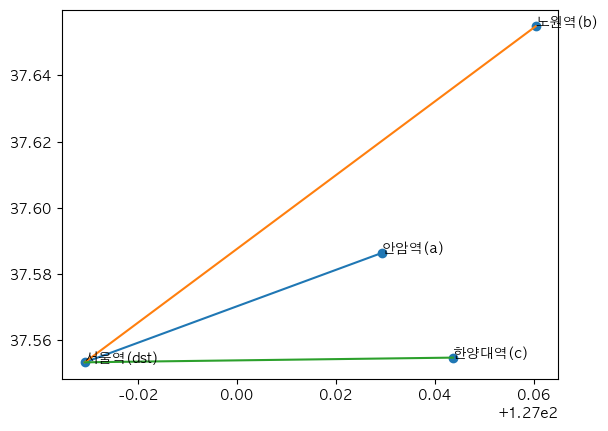

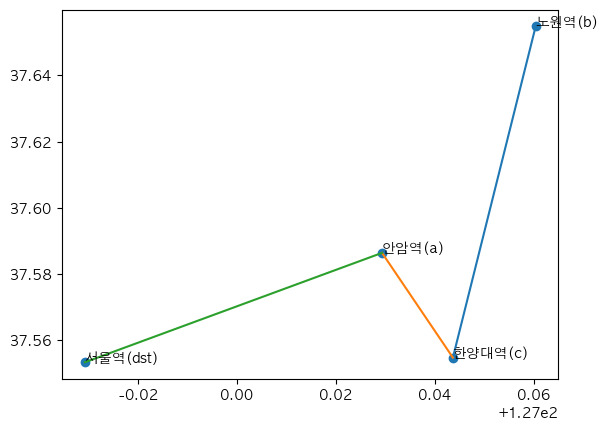

type: A
26200 원 >>> 15108 원 (32.56+9.77 => 42.33% 할인)
42.53 분 >>> 77.92 분 ( => 83.19% 증가)

14100 원 >>> 8647 원 (32.56+6.10 => 38.67% 할인)
34.18 분 >>> 51.95 분 ( => 51.97% 증가)

13800 원 >>> 9306 원 (32.56+0.00 => 32.56% 할인)
33.67 분 >>> 33.67 분 ( => 0.00% 증가)

동승정보
경유지 >> ['노원역', '한양대역', '안암역', '서울역']
11092원 할인(-42.33%) / 35.38분 지연(+83.19%)
5453원 할인(-38.67%) / 17.77분 지연(+51.97%)
4494원 할인(-32.56%) / 0.00분 지연(+0.00%)


In [29]:
if __name__ == "__main__":
    # input
    key='A' # 도착지 동일
    src = ['안암역','노원역','한양대역']
    dst = ['서울역']

    # 전처리
    src.extend(dst)
    loc_info = {i :[src[i]] for i in range(len(src))}

    # 함수호출
    settlement = settlement_algorithm(key,loc_info)

    individual_move = settlement.individual_move()
    routing_move = settlement.routing_move()
    optimizer = settlement.settlement_optimizer()


    individual_distance = individual_move['individual_distance']
    individual_duration = individual_move['individual_duration']
    individual_cost = individual_move['individual_cost']
    passenger_routing = individual_move['passenger_routing']

    routing_distance = routing_move['routing_distance']
    routing_duration = routing_move['routing_duration']
    routing_cost = routing_move['routing_cost']
    delay_ratio = routing_move['delay_ratio']

    I1, I2, I3 = individual_cost
    R1, R2, R3 = delay_ratio

    print(f'type: {key}')
    print(f'{I1} 원 >>> {int((1-alpha-beta*R1)*I1)} 원 ({alpha*100:.2f}+{beta*R1*100:.2f} => {(alpha+beta*R1)*100:.2f}% 할인)')
    print(f'{individual_duration[0]/60:.2f} 분 >>> {routing_duration[0]/60:.2f} 분 ( => {(routing_duration[0]-individual_duration[0])/individual_duration[0]*100:.2f}% 증가)')
    print()
    print(f'{I2} 원 >>> {int((1-alpha-beta*R2)*I2)} 원 ({alpha*100:.2f}+{beta*R2*100:.2f} => {(alpha+beta*R2)*100:.2f}% 할인)')
    print(f'{individual_duration[1]/60:.2f} 분 >>> {routing_duration[1]/60:.2f} 분 ( => {(routing_duration[1]-individual_duration[1])/individual_duration[1]*100:.2f}% 증가)')
    print()
    print(f'{I3} 원 >>> {int((1-alpha-beta*R3)*I3)} 원 ({alpha*100:.2f}+{beta*R3*100:.2f} => {(alpha+beta*R3)*100:.2f}% 할인)')
    print(f'{individual_duration[2]/60:.2f} 분 >>> {routing_duration[2]/60:.2f} 분 ( => {(routing_duration[2]-individual_duration[2])/individual_duration[2]*100:.2f}% 증가)')
    print()
    routing_individual_cost = [int((1-alpha-beta*R1)*I1),int((1-alpha-beta*R2)*I2),int((1-alpha-beta*R3)*I3)]
    print('동승정보')
    print(f'경유지 >> {passenger_routing}')
    print(f'{I1-int((1-alpha-beta*R1)*I1)}원 할인(-{(alpha+beta*R1)*100:.2f}%) / {(routing_duration[0]-individual_duration[0])/60:.2f}분 지연(+{(routing_duration[0]-individual_duration[0])/individual_duration[0]*100:.2f}%)')
    print(f'{I2-int((1-alpha-beta*R2)*I2)}원 할인(-{(alpha+beta*R2)*100:.2f}%) / {(routing_duration[1]-individual_duration[1])/60:.2f}분 지연(+{(routing_duration[1]-individual_duration[1])/individual_duration[1]*100:.2f}%)')
    print(f'{I3-int((1-alpha-beta*R3)*I3)}원 할인(-{(alpha+beta*R3)*100:.2f}%) / {(routing_duration[2]-individual_duration[2])/60:.2f}분 지연(+{(routing_duration[2]-individual_duration[2])/individual_duration[2]*100:.2f}%)')
    # print()
    # print('혼자탔을 때')
    # print(f'합계 : {sum(individual_cost)} 원')
    # print([f'{rou} 원' for rou in individual_cost])
    # print([f'{rou/1000:.2f} km' for rou in individual_distance])
    # print([f'{rou/60:.2f} 분' for rou in individual_duration])
    # print()
    # print('동승시')
    # print(f'합계 : {routing_cost[0]} 원')
    # print([f'{rou} 원' for rou in routing_individual_cost])
    # print([f'{rou/1000:.2f} km' for rou in routing_distance])
    # print([f'{rou/60:.2f} 분' for rou in routing_duration])

In [30]:
print(int((1-alpha-beta*R1)*I1)+int((1-alpha-beta*R2)*I2)+int((1-alpha-beta*R3)*I3))
print(routing_cost[0])

33061
32100


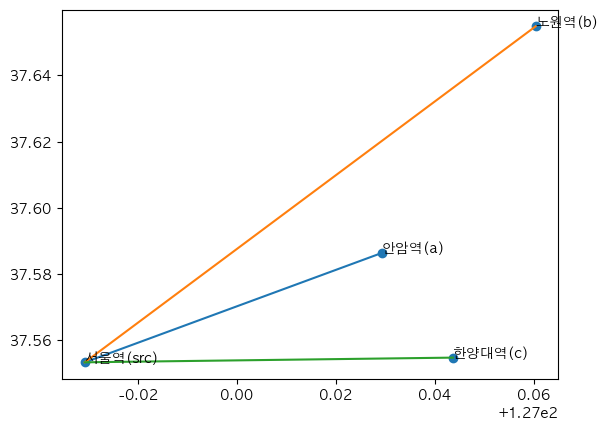

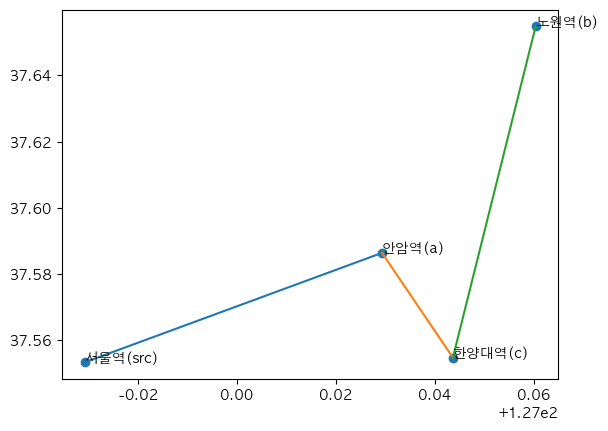

type: B
14200 원 >>> 10806 원 (23.90+0.00 => 23.90% 할인)
36.57 분 >>> 36.57 분 ( => 0.00% 증가)

15400 원 >>> 10785 원 (23.90+6.06 => 29.96% 할인)
33.78 분 >>> 59.83 분 ( => 77.11% 증가)

25400 원 >>> 17508 원 (23.90+7.17 => 31.07% 할인)
53.48 분 >>> 102.25 분 ( => 91.18% 증가)

동승정보
경유지 >> ['노원역', '한양대역', '안암역', '서울역']
3394원 할인(-23.90%) / 0.00분 지연(+0.00%)
4615원 할인(-29.96%) / 26.05분 지연(+77.11%)
7892원 할인(-31.07%) / 48.77분 지연(+91.18%)

혹시가 얻는 최종 이익 >> 


In [42]:
if __name__ == "__main__":

    gamma = 0 # 혹시의 수익
    eplison = 0 # 1-{실제택시요금/예상택시요금}

    # input
    key='B' # 출발지 동일
    src = ['서울역']
    dst = ['안암역','노원역','한양대역']

    # 전처리
    src.extend(dst)
    loc_info = {i :[src[i]] for i in range(len(src))}

    # 함수호출
    settlement = settlement_algorithm(key,loc_info)

    individual_move = settlement.individual_move()
    routing_move = settlement.routing_move()
    optimizer = settlement.settlement_optimizer(UB=0.8, LB=0.3, gamma=gamma, eplison=eplison)


    individual_distance = individual_move['individual_distance']
    individual_duration = individual_move['individual_duration']
    individual_cost = individual_move['individual_cost']

    routing_distance = routing_move['routing_distance']
    routing_duration = routing_move['routing_duration']
    routing_cost = routing_move['routing_cost']
    delay_ratio = routing_move['delay_ratio']

    I1, I2, I3 = individual_cost
    R1, R2, R3 = delay_ratio

    print(f'type: {key}')
    print(f'{I1} 원 >>> {int((1-alpha-beta*R1)*I1)} 원 ({alpha*100:.2f}+{beta*R1*100:.2f} => {(alpha+beta*R1)*100:.2f}% 할인)')
    print(f'{individual_duration[0]/60:.2f} 분 >>> {routing_duration[0]/60:.2f} 분 ( => {(routing_duration[0]-individual_duration[0])/individual_duration[0]*100:.2f}% 증가)')
    print()
    print(f'{I2} 원 >>> {int((1-alpha-beta*R2)*I2)} 원 ({alpha*100:.2f}+{beta*R2*100:.2f} => {(alpha+beta*R2)*100:.2f}% 할인)')
    print(f'{individual_duration[1]/60:.2f} 분 >>> {routing_duration[1]/60:.2f} 분 ( => {(routing_duration[1]-individual_duration[1])/individual_duration[1]*100:.2f}% 증가)')
    print()
    print(f'{I3} 원 >>> {int((1-alpha-beta*R3)*I3)} 원 ({alpha*100:.2f}+{beta*R3*100:.2f} => {(alpha+beta*R3)*100:.2f}% 할인)')
    print(f'{individual_duration[2]/60:.2f} 분 >>> {routing_duration[2]/60:.2f} 분 ( => {(routing_duration[2]-individual_duration[2])/individual_duration[2]*100:.2f}% 증가)')
    print()
    routing_individual_cost = [int((1-alpha-beta*R1)*I1),int((1-alpha-beta*R2)*I2),int((1-alpha-beta*R3)*I3)]
    print('동승정보')
    print(f'경유지 >> {passenger_routing}')
    print(f'{I1-int((1-alpha-beta*R1)*I1)}원 할인(-{(alpha+beta*R1)*100:.2f}%) / {(routing_duration[0]-individual_duration[0])/60:.2f}분 지연(+{(routing_duration[0]-individual_duration[0])/individual_duration[0]*100:.2f}%)')
    print(f'{I2-int((1-alpha-beta*R2)*I2)}원 할인(-{(alpha+beta*R2)*100:.2f}%) / {(routing_duration[1]-individual_duration[1])/60:.2f}분 지연(+{(routing_duration[1]-individual_duration[1])/individual_duration[1]*100:.2f}%)')
    print(f'{I3-int((1-alpha-beta*R3)*I3)}원 할인(-{(alpha+beta*R3)*100:.2f}%) / {(routing_duration[2]-individual_duration[2])/60:.2f}분 지연(+{(routing_duration[2]-individual_duration[2])/individual_duration[2]*100:.2f}%)')
    print()
    print(f'혹시가 얻는 최종 이익 >> ')
    # print()
    # print('혼자탔을 때')
    # print(f'합계 : {sum(individual_cost)} 원')
    # print([f'{rou} 원' for rou in individual_cost])
    # print([f'{rou/1000:.2f} km' for rou in individual_distance])
    # print([f'{rou/60:.2f} 분' for rou in individual_duration])
    # print()
    # print('동승시')
    # print(f'합계 : {routing_cost[0]} 원')
    # print([f'{rou} 원' for rou in routing_individual_cost])
    # print([f'{rou/1000:.2f} km' for rou in routing_distance])
    # print([f'{rou/60:.2f} 분' for rou in routing_duration])

In [43]:
print(int((1-alpha-beta*R1)*I1)+int((1-alpha-beta*R2)*I2)+int((1-alpha-beta*R3)*I3))
print(routing_cost[-1])

39099
39100
